In [1]:
import torch
import torchvision
from torch import nn

In [2]:
## DISCRIMINATOR CLASS

class Discriminator(nn.Module):
    def __init__(self, image_dim):
        super().__init__()
        
        self.disc = nn.Sequential(
            nn.Linear(image_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.disc(x)

In [3]:
## GENERATOR CLASS

class Generator(nn.Module):
    def __init__(self, z_dim, image_dim):
        super().__init__()
        
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, image_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.gen(x)

In [26]:
## DEVICE AGNOSTIC CODE
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## HYPERPARAMETERS
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1 # 784
batch_size = 32
num_epochs = 500

In [18]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

fixed_noise = torch.randn((batch_size, z_dim)).to(device)

## TRANSFORMS
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

dataset = torchvision.datasets.MNIST(root='dataset/', transform=transforms, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [19]:
# Function to show an image
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, label = next(iter(dataloader))

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


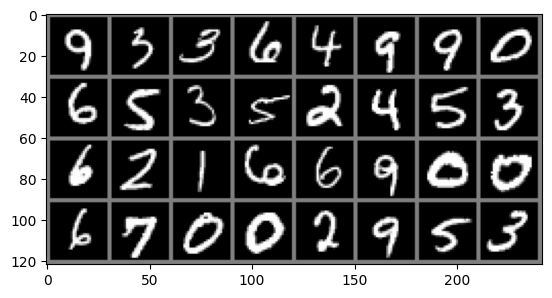

In [20]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('' for j in range(4)))

In [21]:
## SETTING OPTIMIZER AND LOSS FUNCTION
optimizer_disc = torch.optim.Adam(params=disc.parameters(), lr=lr)
optimizer_gen = torch.optim.Adam(params=gen.parameters(), lr=lr)
criterion = torch.nn.BCELoss()

In [25]:
from torch.utils.tensorboard import SummaryWriter

writer_fake = SummaryWriter(f"runs/GAN_MNIST_500_eps/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST_500_eps/real")

In [27]:
step=0
for epoch in range(num_epochs):
    for batch_idx, (real_example, labels) in enumerate(dataloader):
        real_example = real_example.view(-1, 784).to(device)
        batch_size = real_example.shape[0]
        
        ## Train Discriminator: max log(D(real_example)) + log(1-D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_example = gen(noise)
        
        #### discriminator prediction on real examples
        disc_pred_on_real = disc(real_example).view(-1)
        loss_D_real = criterion(disc_pred_on_real, torch.ones_like(disc_pred_on_real))
        
        #### discriminator prediction on generated (fake) examples
        disc_pred_on_fake = disc(fake_example).view(-1)
        loss_D_fake = criterion(disc_pred_on_fake, torch.zeros_like(disc_pred_on_fake))
        
        #### total loss of discriminator
        loss_D = (loss_D_fake + loss_D_real) / 2
        
        #### discriminator zero grad
        disc.zero_grad()
        
        #### discriminator backprop
        loss_D.backward(retain_graph=True)
        
        #### discriminator optimizer step
        optimizer_disc.step()
        
        ## Train Generator: min log(1-D(G(z))) <--> max log(D(G(z)))
        output = disc(fake_example).view(-1)
        loss_G = criterion(output, torch.ones_like(output))
        
        #### generator zero grad
        gen.zero_grad()
        
        #### generator backprop
        loss_G.backward()
        
        #### generator optimizer step
        optimizer_gen.step()
        
        if batch_idx == 0:
            print(
                f"Epoch[{epoch} / {num_epochs}] \ "
                f"Loss D: {loss_D:.4f}, Loss G: {loss_G:.4f}"
            )
            
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1,1,28,28)
                data = real_example.reshape(-1,1,28,28)
                img_grid_fake  = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real  = torchvision.utils.make_grid(data, normalize=True)
                
                writer_fake.add_image(
                    "MNIST Fake Images", img_grid_fake, global_step=step
                )
                
                writer_real.add_image(
                    "MNIST Real Images", img_grid_real, global_step=step
                )
                
                step += 1
        

Epoch[0 / 500] \ Loss D: 0.4103, Loss G: 1.3892
Epoch[1 / 500] \ Loss D: 0.5739, Loss G: 0.8432
Epoch[2 / 500] \ Loss D: 0.6593, Loss G: 0.8922
Epoch[3 / 500] \ Loss D: 0.4477, Loss G: 1.1961
Epoch[4 / 500] \ Loss D: 0.7568, Loss G: 0.8308
Epoch[5 / 500] \ Loss D: 0.4835, Loss G: 1.0272
Epoch[6 / 500] \ Loss D: 0.6708, Loss G: 0.7896
Epoch[7 / 500] \ Loss D: 0.7897, Loss G: 0.9799
Epoch[8 / 500] \ Loss D: 0.5608, Loss G: 1.0727
Epoch[9 / 500] \ Loss D: 0.7922, Loss G: 0.9748
Epoch[10 / 500] \ Loss D: 0.5511, Loss G: 1.1872
Epoch[11 / 500] \ Loss D: 0.4596, Loss G: 1.2074
Epoch[12 / 500] \ Loss D: 0.7677, Loss G: 0.8456
Epoch[13 / 500] \ Loss D: 0.9581, Loss G: 0.5360
Epoch[14 / 500] \ Loss D: 0.5537, Loss G: 1.1359
Epoch[15 / 500] \ Loss D: 0.8146, Loss G: 1.0000
Epoch[16 / 500] \ Loss D: 0.5481, Loss G: 1.3371
Epoch[17 / 500] \ Loss D: 0.5313, Loss G: 1.0774
Epoch[18 / 500] \ Loss D: 0.6605, Loss G: 1.1709
Epoch[19 / 500] \ Loss D: 0.7031, Loss G: 0.9588
Epoch[20 / 500] \ Loss D: 0.57

In [31]:
model_path = 'generator.pth'
torch.save(gen.state_dict(), model_path)

model_path = 'discriminator.pth'
torch.save(disc.state_dict(), model_path)